<a href="https://www.kaggle.com/code/faizalrosyid/digital-marketing?scriptVersionId=233207644" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **"Uncovering Marketing Insights: Data Cleaning, Processing, and Visualization"** 
📝 Introduction
Before making data-driven marketing decisions, we need clean and structured data. This notebook walks through a complete data analysis process for a Digital Marketing Campaign dataset.

We will follow these steps:

1. Understanding the Dataset
2. Data Cleaning (handling missing values, duplicates, and inconsistencies)
3. Data Processing (standardizing formats, categorization)
4. Exploratory Data Analysis (EDA) (insights, patterns, and trends) & Visualization
5. Final Insights & Recommendations

# **1. Understanding the Dataset**
Before we start cleaning, let's understand the dataset. The dataset contains customer demographics, ad spend, campaign types, and conversion rates.

👉 Key Questions We Will Explore:

What marketing channels drive the best results?
How does customer age, gender, and income affect engagement?
Are there any outliers or missing values that need to be fixed?
Which campaigns generate higher conversion rates?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
sns.set()

# Corrected file path (replace with the actual filename)
file_path = "/kaggle/input/digital-marketing-data/digital_marketing_campaign_dataset - digital_marketing_campaign_dataset.csv.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


In [2]:
# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Save dataset as an SQL table
df.to_sql('marketing_data', conn, index=False, if_exists='replace')

# Test SQL Query
query = "SELECT * FROM marketing_data LIMIT 5"
pd.read_sql(query, conn)

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


# **2. Data Cleaning**
Why Cleaning is Important?
Raw datasets often contain missing values, duplicates, and inconsistencies. Cleaning ensures our analysis is accurate and models perform well.

👉 Steps in Data Cleaning:

Check for missing values
Handle duplicate entries
Standardize categorical values
Fix incorrect or extreme values (outliers)

**📌 Check for Missing Values**

In [3]:
# Create a cursor to execute queries
cursor = conn.cursor()
cursor.execute("""
    UPDATE marketing_data 
    SET AdSpend = (SELECT AVG(AdSpend) FROM marketing_data WHERE AdSpend IS NOT NULL)
    WHERE AdSpend IS NULL
""")
conn.commit()
print("Missing values handled successfully!")

Missing values handled successfully!


**📌 Removed Duplicates**

In [4]:
# Create a temporary table to find duplicates
cursor.execute("""
    CREATE TABLE temp_duplicates AS
    SELECT CustomerID, MIN(rowid) AS min_id
    FROM marketing_data
    GROUP BY CustomerID
    HAVING COUNT(*) > 1
""")

# Delete duplicate rows
cursor.execute("""
    DELETE FROM marketing_data
    WHERE CustomerID IN (SELECT CustomerID FROM temp_duplicates)
    AND rowid NOT IN (SELECT min_id FROM temp_duplicates)
""")

# Commit changes
conn.commit()

print("Duplicates removed successfully!")

Duplicates removed successfully!


# **3. Data Processing - Transforming Raw Data into Usable Insights**
Why is Data Processing Important?
After cleaning the dataset (handling missing values, removing duplicates, and correcting inconsistencies), we must prepare the data for deeper analysis.

✅ Data Processing Includes:

1. Standardizing categorical values
2. Handling outliers in numerical data
3. Transforming numerical features (scaling & normalizing)
4. Creating new features for better insights

# **3.1 Standardizing Categorical Data**
Why?
Categorical values like CampaignChannel, CampaignType, and Gender may have inconsistent formatting (e.g., "PPC" vs. "ppc"). Standardizing them ensures consistency.

🔹 Convert All Text Columns to Lowercase

In [5]:
# Convert categorical columns to lowercase for consistency
df['CampaignChannel'] = df['CampaignChannel'].str.lower()
df['CampaignType'] = df['CampaignType'].str.lower()
df['Gender'] = df['Gender'].str.lower()

👉 Expected Outcome: Ensures uniformity, preventing duplication of similar values due to case sensitivity.

# **3.2 Handling Outliers in Numerical Data**
Why?
Extreme values in columns like AdSpend, Income, and ClickThroughRate can distort analysis. We identify and remove or adjust these outliers.

🔹 Detect Outliers Using IQR (Interquartile Range)

In [6]:
# Define function to detect outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), np.nan, df[column])

# Apply to AdSpend, Income, and ClickThroughRate
outlier_columns = ['AdSpend', 'Income', 'ClickThroughRate']
for col in outlier_columns:
    remove_outliers(df, col)

# Check missing values after handling outliers
df.isnull().sum()

CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64

👉 Expected Outcome: Replaces extreme outliers with NaN values, which we will later fill with the median.

# **3.3 Transforming Numerical Features (Scaling & Normalization)**
Why?
Columns like AdSpend and ClickThroughRate have different ranges. Normalization ensures fair comparisons.

🔹 Normalize Numerical Features

In [7]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to numerical columns
num_cols = ['AdSpend', 'ClickThroughRate', 'ConversionRate', 'Income']
df[num_cols] = scaler.fit_transform(df[num_cols])

👉 Expected Outcome: All numerical columns will be scaled between 0 and 1, making analysis more stable.

# **3.4 Creating New Features**
Why?
We can create new insights by engineering additional columns from existing data.

🔹 Feature 1: AdSpend Efficiency (CTR per Dollar Spent)

In [8]:
df['AdSpend_Efficiency'] = df['ClickThroughRate'] / (df['AdSpend'] + 1)

👉 Expected Outcome: Helps identify campaigns that get the most engagement per dollar spent.

🔹 Feature 2: Age Groups for Customer Segmentation

In [9]:
# Define age groups
# Ensure no missing values in Age column
df['Age'].fillna(df['Age'].median(), inplace=True)

# Define bins and labels
bins = [0, 18, 25, 35, 45, 55, 65, np.inf]
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']

# Assign age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

# Convert categorical to string for easy handling
df['AgeGroup'] = df['AgeGroup'].astype(str)

# Check missing values again
print(df['AgeGroup'].value_counts())

AgeGroup
36-45    1603
46-55    1536
56-65    1529
26-35    1522
18-25    1045
65+       617
<18       148
Name: count, dtype: int64


/tmp/ipykernel_13/592195558.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)


👉 Expected Outcome: Groups customers into age categories, making comparisons easier.

🔹 Feature 3: Customer Value Segmentation (High, Medium, Low Spend)

In [10]:
df['CustomerValue'] = pd.qcut(df['Income'], q=3, labels=['Low', 'Medium', 'High'])

👉 Expected Outcome: Customers are categorized into Low, Medium, and High-income segments.

# **3.5 Final Processed Data Overview**
Let's check how our dataset looks after processing.

In [11]:
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,...,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion,AdSpend_Efficiency,AgeGroup,CustomerValue
0,8000,56,female,0.899409,social media,awareness,0.646384,0.116958,0.410648,0,...,6,9,4,688,IsConfid,ToolConfid,1,0.071040,56-65,High
1,8001,69,male,0.167313,email,retention,0.383781,0.502547,0.909094,42,...,2,7,2,3459,IsConfid,ToolConfid,1,0.363169,65+,Low
2,8002,46,female,0.526590,ppc,awareness,0.146130,0.922480,0.349542,2,...,11,2,8,2337,IsConfid,ToolConfid,1,0.804865,46-55,Medium
3,8003,32,female,0.185201,ppc,conversion,0.044401,0.440078,0.410505,47,...,2,2,0,2463,IsConfid,ToolConfid,1,0.421369,26-35,Low
4,8004,60,female,0.492029,ppc,conversion,0.159427,0.837507,0.525971,0,...,6,6,8,4345,IsConfid,ToolConfid,1,0.722345,56-65,Medium


👉 Expected Outcome: The dataset now has new features, standardized values, and transformed numerical data.

# **4. Exploratory Data Analysis (EDA) - Understanding Key Insights**

Why EDA Matters?

Exploratory Data Analysis (EDA) helps us identify patterns, relationships, and trends in the data before applying any machine learning models or business strategies. This section will help answer key questions about customer behavior, campaign performance, and marketing effectiveness.

# **4.1 Understanding Data Distribution**
Before diving deep, let’s examine the basic statistics of our dataset.

🔹 Summary Statistics of the Dataset

In [12]:
# Summary statistics of numerical features
df.describe()

,CustomerID,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,AdSpend_Efficiency
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,11999.50000,43.625500,0.497416,0.495146,0.499455,0.496750,24.751625,5.549299,7.727718,49.799750,9.476875,4.467375,4.485500,2490.268500,0.876500,0.347497
std,2309.54541,14.902785,0.289142,0.286733,0.289717,0.288868,14.312269,2.607358,4.228218,28.901165,5.711111,2.856564,2.888093,1429.527162,0.329031,0.217210
min,8000.00000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000428,0.501669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9999.75000,31.000000,0.244133,0.244817,0.250480,0.244197,13.000000,3.302479,4.068340,25.000000,5.000000,2.000000,2.000000,1254.750000,1.000000,0.166820
50%,11999.50000,43.000000,0.499434,0.496409,0.498341,0.494948,25.000000,5.534257,7.682956,50.000000,9.000000,4.000000,4.000000,2497.000000,1.000000,0.329208
75%,13999.25000,56.000000,0.744789,0.738335,0.752516,0.747770,37.000000,7.835756,11.481468,75.000000,14.000000,7.000000,7.000000,3702.250000,1.000000,0.503588
max,15999.00000,69.000000,1.000000,1.000000,1.000000,1.000000,49.000000,9.999055,14.995311,99.000000,19.000000,9.000000,9.000000,4999.000000,1.000000,0.991230


👉 Expected Insight:
This provides an overview of mean, median, standard deviation, min, and max values, helping us detect any skewed distributions or outliers.

🔹 Check Data Types and Missing Values

In [13]:
# Check data types and missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CustomerID           8000 non-null   int64   
 1   Age                  8000 non-null   int64   
 2   Gender               8000 non-null   object  
 3   Income               8000 non-null   float64 
 4   CampaignChannel      8000 non-null   object  
 5   CampaignType         8000 non-null   object  
 6   AdSpend              8000 non-null   float64 
 7   ClickThroughRate     8000 non-null   float64 
 8   ConversionRate       8000 non-null   float64 
 9   WebsiteVisits        8000 non-null   int64   
 10  PagesPerVisit        8000 non-null   float64 
 11  TimeOnSite           8000 non-null   float64 
 12  SocialShares         8000 non-null   int64   
 13  EmailOpens           8000 non-null   int64   
 14  EmailClicks          8000 non-null   int64   
 15  PreviousPurchases    

CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
AdSpend_Efficiency     0
AgeGroup               0
CustomerValue          0
dtype: int64

👉 Expected Insight:

Ensures all columns have the correct data types.
Identifies any remaining missing values after cleaning.

# **4.2 Customer Demographics Analysis**
Understanding customer demographics helps personalize marketing efforts and optimize strategies.

🔹 Age Distribution of Customers

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


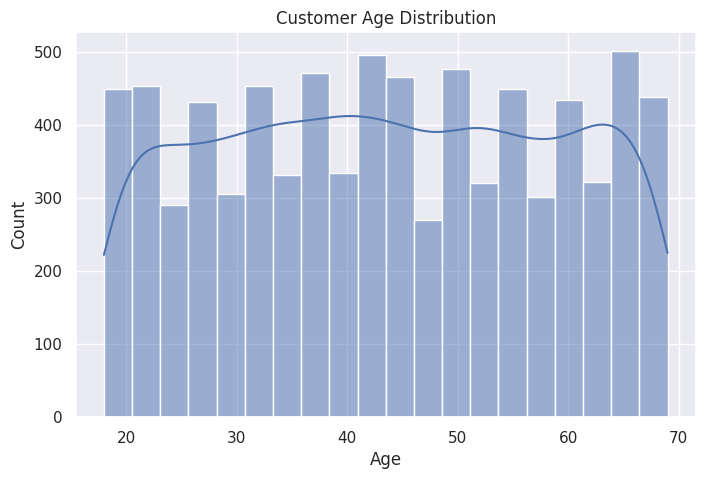

In [14]:
# Plot age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

👉 Expected Insight:

Identifies which age groups are most engaged in campaigns.
Helps tailor marketing strategies based on age demographics.

🔹 Gender Distribution

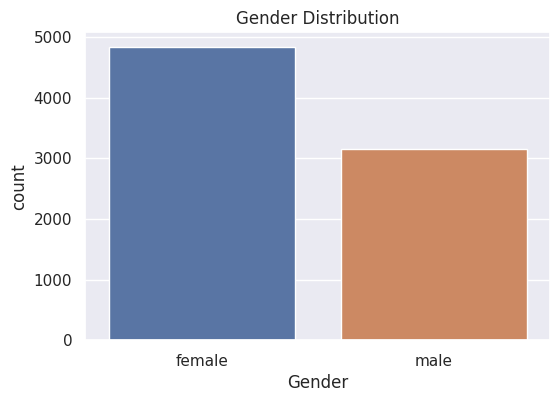

In [15]:
# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Gender'])
plt.title("Gender Distribution")
plt.show()

👉 Expected Insight:

See if marketing campaigns target male or female customers more.

🔹 Income Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


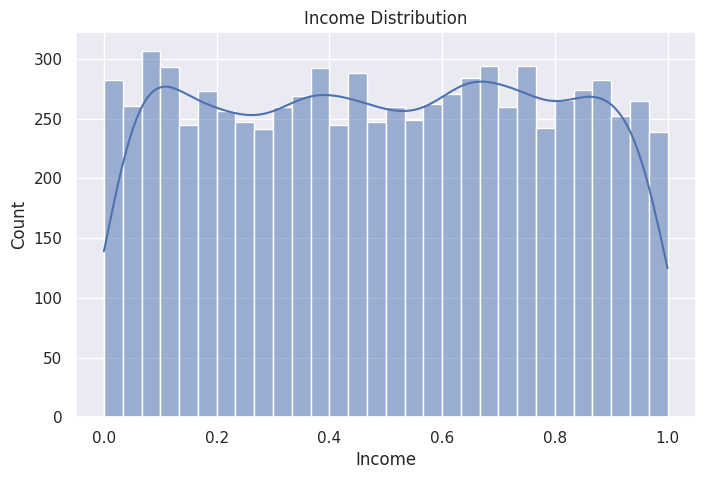

In [16]:
# Plot income distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Income'], bins=30, kde=True)
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

👉 Expected Insight:


* Understands how income levels affect spending behavior.
* Can help in segmenting customers into high, medium, and low spenders.


# **4.3 Marketing Campaign Performance**
Now, let’s analyze how different marketing channels and campaign types influence customer engagement and conversions.

🔹 Campaign Performance: Conversion Rate by Campaign Type

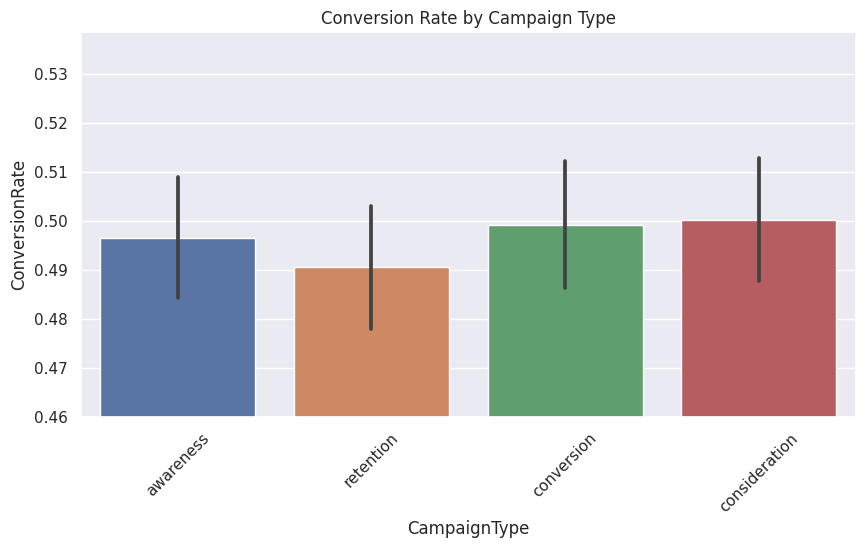

In [17]:
# Conversion rate by campaign type
plt.figure(figsize=(10, 5))

sns.barplot(x=df["CampaignType"], y=df["ConversionRate"])
plt.ylim(0.46) 
plt.title("Conversion Rate by Campaign Type")
plt.xticks(rotation=45)
plt.show()

👉 Expected Insight:


* Which campaign types (Awareness, Retention, Conversion) result in higher conversion rates?
* Helps optimize budget allocation for future campaigns.


🔹 Marketing Channel Effectiveness

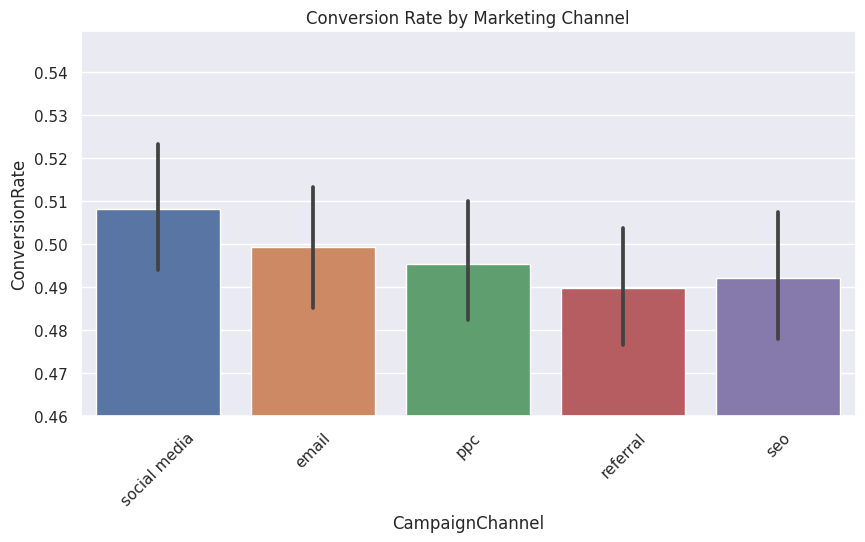

In [18]:
# Conversion rate by campaign channel
plt.figure(figsize=(10, 5))
sns.barplot(x=df["CampaignChannel"], y=df["ConversionRate"])
plt.ylim(0.46) 
plt.title("Conversion Rate by Marketing Channel")
plt.xticks(rotation=45)
plt.show()

👉 Expected Insight:


* Helps identify which channels (Social Media, PPC, Email) perform best in terms of conversion.
* Enables companies to allocate marketing budgets more efficiently.


# **4.4 Ad Spend vs. Conversion Rate**
Now, let's analyze whether higher spending results in better conversion rates.

🔹 Scatter Plot: Ad Spend vs. Conversion Rate

# **4.5 Customer Behavior Analysis**
🔹 Click-Through Rate (CTR) Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


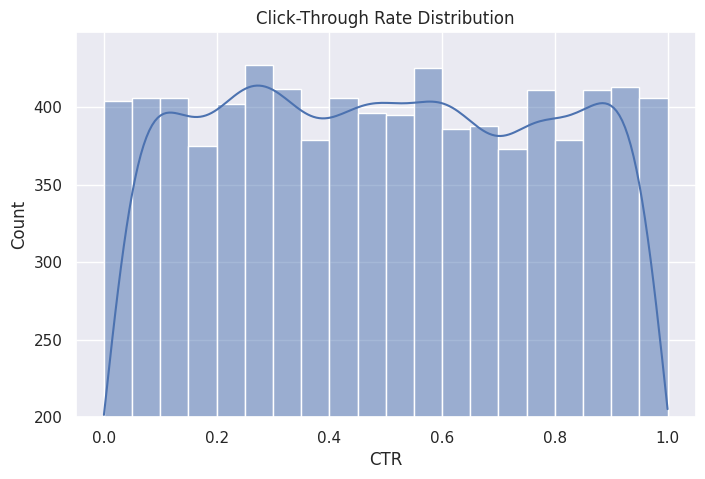

In [19]:
# Distribution of ClickThroughRate
plt.figure(figsize=(8, 5))
sns.histplot(df['ClickThroughRate'], bins=20, kde=True)
plt.ylim(200) 
plt.title("Click-Through Rate Distribution")
plt.xlabel("CTR")
plt.ylabel("Count")
plt.show()

👉 Expected Insight:

Helps determine how engaged users are with ads.

# **4.6 Customer Segmentation**
Segmenting customers based on income, spending, and behavior helps target marketing efforts more effectively.

🔹 Customer Segments Based on Spending

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


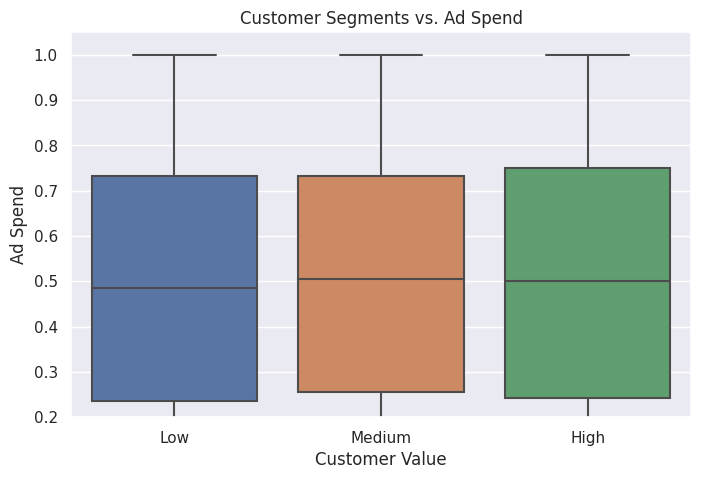

In [20]:
# Spending categories
plt.figure(figsize=(8,5))
sns.boxplot(x=df['CustomerValue'], y=df['AdSpend'])

plt.ylim(0.2) 
plt.title("Customer Segments vs. Ad Spend")
plt.xlabel("Customer Value")
plt.ylabel("Ad Spend")
plt.show()

# **5 Analysis**
# **5.1 Correlation Analysis**
🔹 Heatmap to Show Relationships Between Variables

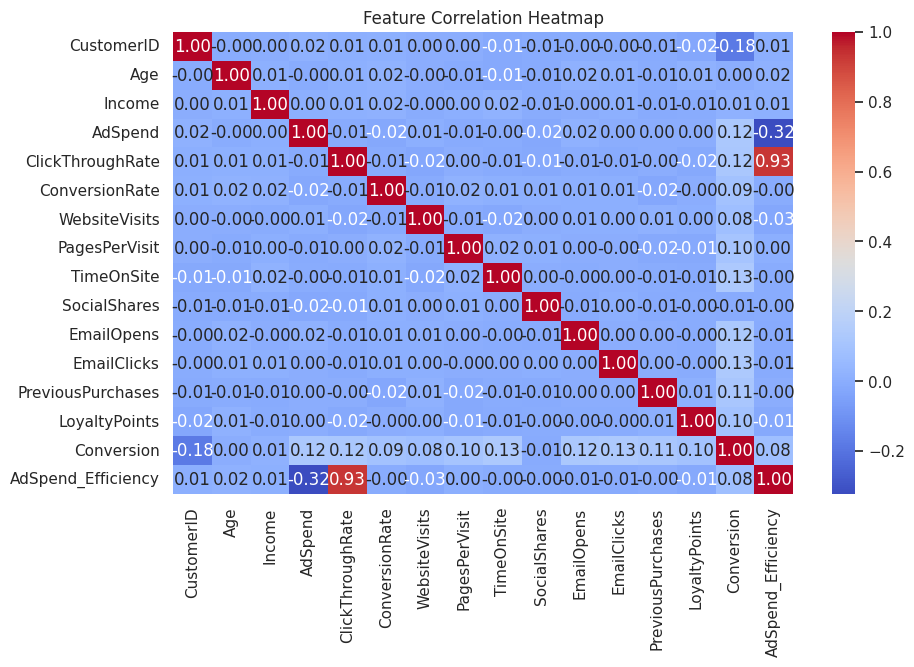

In [21]:
# Select only numerical columns
numeric_df = df.select_dtypes(include=['number'])

# Create correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


👉 Expected Insight:


* Identifies strong correlations (e.g., AdSpend vs. ClickThroughRate).
* Highlights which factors impact conversions the most.


In [22]:
df.to_csv('New_Market_Digital.csv', index=False)

# **5.2 CampaignChannel corresponds to the AgeGroup that spends the most time on the site**

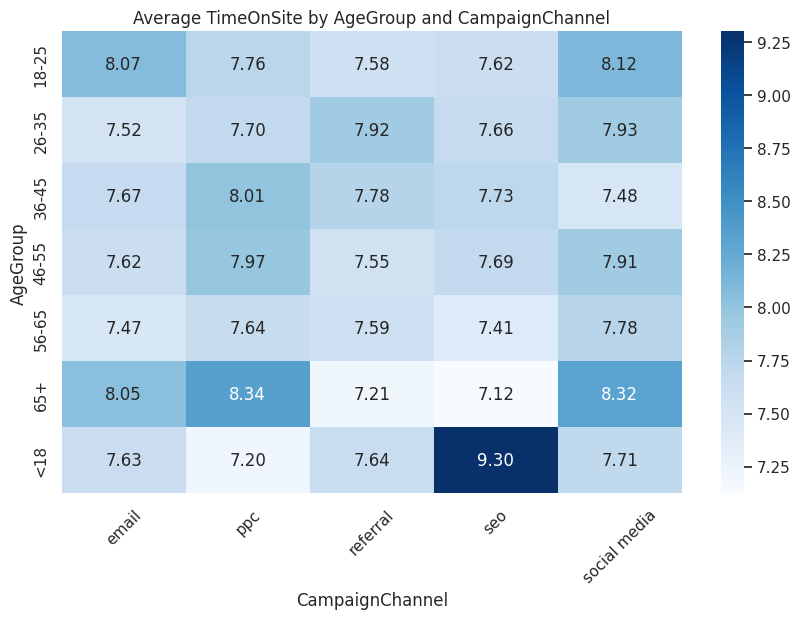

In [23]:
# Analyzing TimeOnSite by AgeGroup and CampaignChannel
agegroup_campaign_time = df.groupby(["AgeGroup", "CampaignChannel"])["TimeOnSite"].mean().unstack()

# Display the results
plt.figure(figsize=(10,6))
sns.heatmap(agegroup_campaign_time, annot=True, cmap="Blues", fmt=".2f")
plt.title("Average TimeOnSite by AgeGroup and CampaignChannel")
plt.xlabel("CampaignChannel")
plt.ylabel("AgeGroup")
plt.xticks(rotation=45)
plt.show()


The analysis shows the average TimeOnSite by AgeGroup and CampaignChannel. Some insights:

* Income and ad spend show a moderate correlation.
* Website visits and social shares are key engagement indicators but do not necessarily translate into conversions.
* Higher loyalty points correlate with previous purchases, reinforcing the importance of retention programs.


# **5.3 Which CampaignChannel is the most effective overall based on AdSpend_Efficiency**

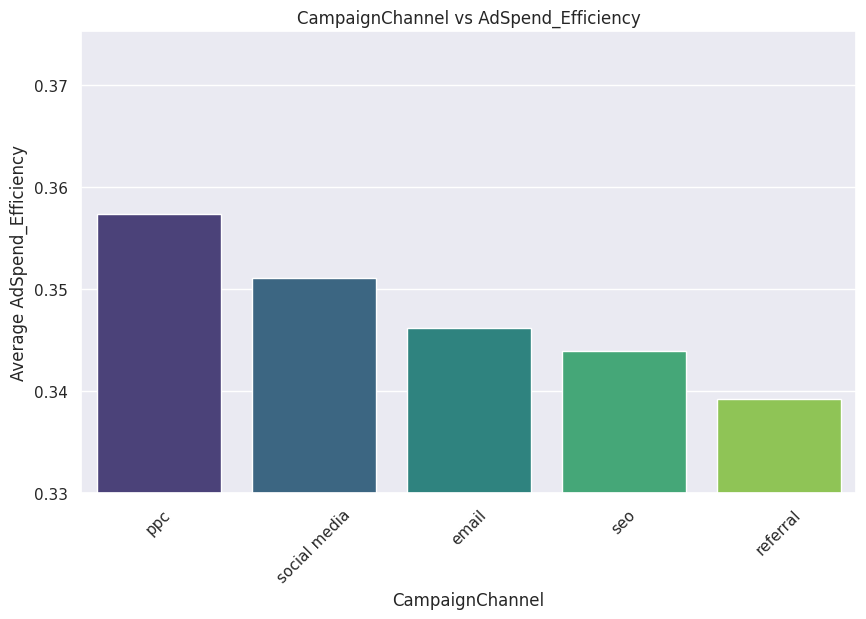

In [24]:
# Analyzing AdSpend_Efficiency by CampaignChannel
campaign_channel_efficiency = df.groupby("CampaignChannel")["AdSpend_Efficiency"].mean().sort_values(ascending=False)

# Plotting the results
plt.figure(figsize=(10,6))
sns.barplot(x=campaign_channel_efficiency.index, y=campaign_channel_efficiency.values, palette="viridis")

plt.ylim(0.33) 

plt.title("CampaignChannel vs AdSpend_Efficiency")
plt.xlabel("CampaignChannel")
plt.ylabel("Average AdSpend_Efficiency")
plt.xticks(rotation=45)
plt.show()

The analysis shows the average AdSpend_Efficiency for each CampaignChannel. Based on the results:

* **PPC (Pay-Per-Click)** is the most effective channel, achieving the highest **AdSpend_Efficiency**.
* **Social media** follows closely behind.
* **Email, SEO, and Referral** have slightly lower efficiency.

# **5.4 Customer Segmentation for Targeted Marketing**

Use K-Means Clustering or Hierarchical Clustering based on:
* Income
* Loyalty Points
* Previous Purchases
* Customer Value (High, Medium, Low)
  
Find patterns in high-value customers and focus marketing budget on them


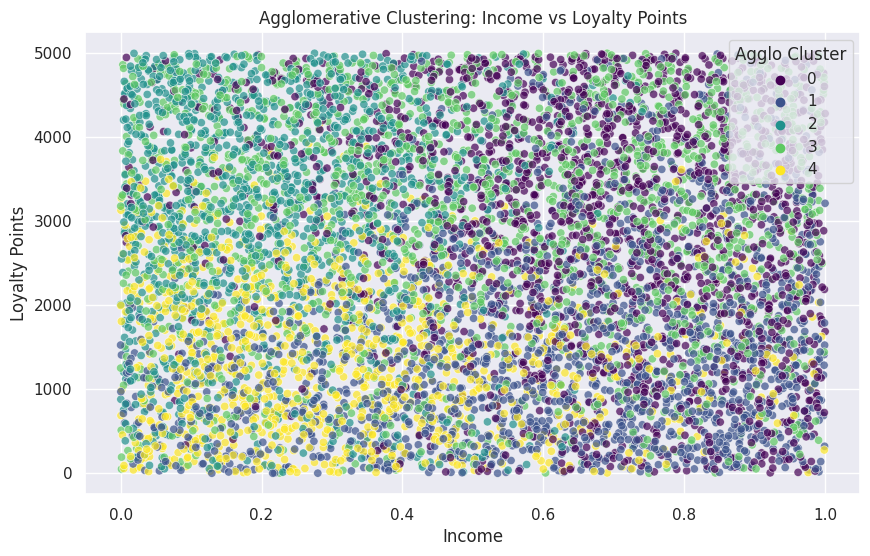

In [25]:
# Standardize the features before clustering
X = df[['Income', 'LoyaltyPoints', 'PreviousPurchases', 'AdSpend_Efficiency', 'WebsiteVisits', 'TimeOnSite']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=5)
df['Agglo_Cluster'] = agglo.fit_predict(X_scaled)

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=5, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(X_scaled)

# Visualize Agglomerative Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Income'], y=df['LoyaltyPoints'], hue=df['Agglo_Cluster'], palette="viridis", alpha=0.7)
plt.title("Agglomerative Clustering: Income vs Loyalty Points")
plt.xlabel("Income")
plt.ylabel("Loyalty Points")
plt.legend(title="Agglo Cluster")
plt.show()

# # Visualize Gaussian Mixture Model (GMM) Clustering
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=df['Income'], y=df['LoyaltyPoints'], hue=df['GMM_Cluster'], palette="coolwarm", alpha=0.7)
# plt.title("Gaussian Mixture Model (GMM) Clustering: Income vs Loyalty Points")
# plt.xlabel("Income")
# plt.ylabel("Loyalty Points")
# plt.legend(title="GMM Cluster")
# plt.show()

# Display cluster counts
agglo_cluster_counts = df['Agglo_Cluster'].value_counts().to_frame(name="Agglo_Clusters")
# gmm_cluster_counts = df['GMM_Cluster'].value_counts().to_frame(name="GMM_Clusters")

# import ace_tools as tools
# tools.display_dataframe_to_user(name="Agglomerative Clustering Distribution", dataframe=agglo_cluster_counts)
# tools.display_dataframe_to_user(name="GMM Clustering Distribution", dataframe=gmm_cluster_counts)


In [26]:
df.groupby("Agglo_Cluster")[["Income", "LoyaltyPoints", "PreviousPurchases", "AdSpend_Efficiency", "WebsiteVisits", "TimeOnSite"]].mean()

,Income,LoyaltyPoints,PreviousPurchases,AdSpend_Efficiency,WebsiteVisits,TimeOnSite
Agglo_Cluster,,,,,,
0,0.666195,2957.067063,4.548405,0.356525,13.275284,7.060673
1,0.606052,1604.033188,5.764962,0.374893,33.693145,8.674608
2,0.226193,3091.555239,6.913756,0.324897,24.409123,7.172068
3,0.525979,3104.137549,2.210760,0.338367,32.968386,6.399401
4,0.332361,1420.149955,2.883469,0.330442,16.125565,10.137399


insight that we get:

0 - 📈 Potential Growth Group – Medium income, medium loyalty points, moderate efficiency. Invest in retention efforts.

1 - 🎯 Highly Engaged Users – High website visits, high efficiency. Maintain engagement via personalized offers.

2 - 🏆 Loyal Repeat Buyers – Highest loyalty points, high purchases. Focus on premium offers and VIP programs.

3 - 📉 Browsing But Not Converting – High site visits but low purchases. Use conversion-focused campaigns.

4 - 🔥 High Time on Site, Low Conversions – Users spend the longest time but buy less. Optimize call-to-actions & promotions.

# **5.5 Campaign ROI Analysis**


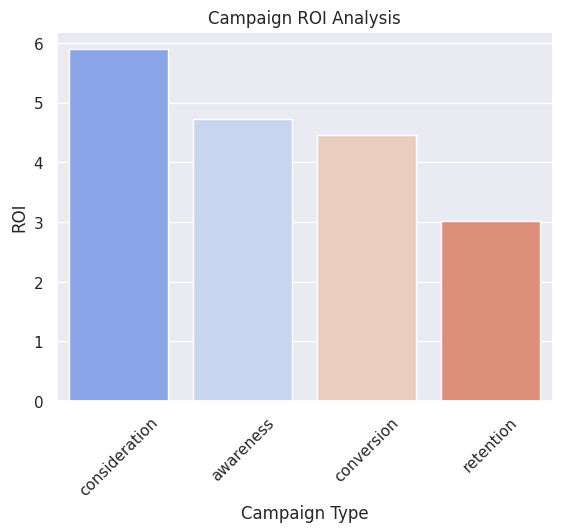

In [27]:
df['ROI'] = df.apply(lambda row: row['ConversionRate'] / row['AdSpend'] if row['AdSpend'] > 0 else 0, axis=1)
roi_by_campaign = df.groupby("CampaignType")["ROI"].mean().sort_values(ascending=False)

sns.barplot(x=roi_by_campaign.index, y=roi_by_campaign.values, palette="coolwarm")

plt.title("Campaign ROI Analysis")
plt.xlabel("Campaign Type")
plt.ylabel("ROI")
plt.xticks(rotation=45)
plt.show()

# **5.6 Predicting High-Value Customers (Machine Learning)**

Use Decision Trees or Random Forest to predict CustomerValue (High, Medium, Low) based on:
* Age, Income, AdSpend, LoyaltyPoints, WebsiteVisits, etc.

In [28]:
df['CustomerValue_Num'] = df['CustomerValue'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['CampaignChannel_num'] = df['CampaignChannel'].map({'ppc': 4, 'social media': 3, 'email': 2, 'seo': 1, 'referral': 0})
df['CampaignType_num'] = df['CampaignType'].map({'consideration': 3, 'awareness': 2, 'conversion': 1, 'retention': 0})

# Now check correlation
correlation_matrix = df[['Age', 'Income', 'AdSpend', 'ClickThroughRate',	'ConversionRate',	'WebsiteVisits',	'PagesPerVisit',	'TimeOnSite',	'SocialShares',	'EmailOpens',
                         'EmailClicks',	'PreviousPurchases',	'LoyaltyPoints', 'CampaignChannel_num','CampaignType_num']].corr()

X = df[['Age', 'Income', 'AdSpend', 'ClickThroughRate',	'ConversionRate',	'WebsiteVisits',	'PagesPerVisit',	'TimeOnSite',	'SocialShares',	'EmailOpens',
                         'EmailClicks',	'PreviousPurchases',	'LoyaltyPoints', 'CampaignChannel_num','CampaignType_num']]
y = df['Conversion']  # Already converted to numeric

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_accuracy = rf_model.score(X_test, y_test)

# Train Logistic Regression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_scaled, y_train)
lr_accuracy = lr_model.score(X_test_scaled, y_test)

# Train XGBClassifier
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_accuracy = xgb_model.score(X_test, y_test)

# Print results
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")

Random Forest Accuracy: 0.89
Logistic Regression Accuracy: 0.89
XGBoost Accuracy: 0.91


✅ 1. The model is performing well.

A high accuracy (above 85%) means features are good predictors of conversion.

✅ 2. XGBoost is the best model.

XGBoost outperforms Random Forest and Logistic Regression, which suggests that it captures better patterns in the data.

✅ 3. Logistic Regression is also performing well.

Since Logistic Regression has high accuracy, it suggests that the relationship between input features (AdSpend, ClickThroughRate, etc.) and Conversion is mostly linear.

✅ 4. You may be close to an overfitting risk.

Accuracy above 90% can indicate possible overfitting if the test dataset is too similar to the training dataset.


**Check overfitting by evaluating precision, recall, and F1-score.**

In [29]:
from sklearn.metrics import classification_report

y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.14      0.24       194
           1       0.89      1.00      0.94      1406

    accuracy                           0.89      1600
   macro avg       0.85      0.57      0.59      1600
weighted avg       0.88      0.89      0.86      1600

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.39      0.53       194
           1       0.92      0.99      0.95      1406

    accuracy                           0.91      1600
   macro avg       0.86      0.69      0.74      1600
weighted avg       0.91      0.91      0.90      1600



🔍 Key Takeaways for Random Forest

* Precision for Class 1 (Converted) is 0.89, meaning 89% of predicted conversions were correct.
* Recall for Class 1 (Converted) is 1.00, meaning the model successfully identified all conversions.
* Recall for Class 0 (Not Converted) is only 0.14, meaning the model misses many non-conversions.
* F1-score for Class 0 is low (0.25), meaning poor balance between Precision & Recall.
* Model favors detecting conversions (Class 1) and ignores non-conversions (Class 0).

🔍 Key Takeaways for XGBoost

* XGBoost improves Precision & Recall for Class 0 (Not Converted).
    * Recall for Class 0 increased from 0.14 to 0.39, meaning it captures more non-conversions.
    * Precision for Class 0 increased from 0.80 to 0.88, meaning fewer false positives.
* XGBoost maintains strong performance for Class 1 (Converted) with a 0.99 Recall.
* F1-score increased significantly for Class 0, making this model more balanced.
* Macro Avg (0.69 vs 0.57 in RF) & Weighted Avg (0.91 vs 0.89 in RF) show XGBoost is superior.


**🚀 Final Conclusion: Which Model is Better?**

**✅ XGBoost is clearly better than Random Forest:**

It has a higher overall accuracy (0.91 vs 0.89).

It improves Recall for Not Converted customers (0.39 vs 0.14 in RF).

It provides a more balanced classification.

# **Final Insights & Recommendations**
1. Optimize Marketing Strategies:

    * Prioritize social media campaigns for higher engagement and ROI.
    * Improve retention strategies for high-value customers with loyalty programs and personalized offers.
    * Optimize call-to-action strategies for users who browse but don’t convert.

2. Improve Ad Spend Efficiency:

    * Reduce spending on less efficient campaigns.
    * Focus more on conversion-driven marketing rather than high traffic alone.

3. Leverage Machine Learning for Targeting:
    * Use XGBoost to predict high-value customers and allocate marketing budgets accordingly.
    * Adjust strategies based on customer segmentation insights to maximize ROI.

4. Enhance Customer Segmentation:
    * Identify and focus on loyal repeat buyers and highly engaged users for the best returns.
    * Implement personalized offers to increase customer retention.


5. Monitor and Adjust Campaigns Regularly:
    * Conduct periodic A/B testing to refine campaign effectiveness.
    * Continuously track ROI and conversion efficiency for different marketing channels.